# Hyperparameter tuning and cross-validation

Test the data on various models using ensemble learning. Determine the best model for use. Notes in this notebook refer to the `middle` velocity point. See `CML_workflow` for full classic ML workflow using cleaned data and generalized notes.

---

### 1. Load packages and open dataset

This example will demonstrate on the middle point.

In [48]:
import pandas as pd
import numpy as np
import plotly.express as px
import time
import matplotlib.pyplot as plt
from pycaret.regression import *

In [49]:
point_name = 'terminus' # 'upstream', 'middle', or 'terminus'
df = pd.read_csv('../data/clean/' + point_name + '_velocity_series_clean.csv')

df.head()

,time,VelocitySeries
0,2015-01-30 12:00:00,2033.7096
1,2015-02-11 12:00:00,2026.7332
2,2015-02-23 12:00:00,2071.6174
3,2015-06-11 12:00:00,2092.8370
4,2015-06-23 12:00:00,2095.4255


Create a monthly rolling average of the data to plot with the velocity data.

In [50]:
# create 12 month moving average
df.rename(columns={'VelocitySeries': 'velocity'}, inplace=True)
df['MA12'] = df['velocity'].rolling(12).mean()

# plot the data and monthly average
fig = px.line(df, x="time", y=["velocity", "MA12"])
fig.update_layout(title='Velocity Series and 12 Month Moving Average for ' + point_name.capitalize() + ' Point')
fig.write_image('../figures/' + point_name + '_12m_moving_avg.png')
fig.show()

Create a series to add to the dataframe for interpretation of time series data. Drop the values that are unnecessary, leaving series, time, and velocity values.

In [51]:
# create a sequence of numbers
df['series'] = np.arange(1,len(df)+1)
df['time'] = pd.to_datetime(df['time'])

# drop unnecessary columns and re-arrange
df = df[['series', 'time', 'velocity']] 

# check the head of the dataset
df.head()

,series,time,velocity
0,1,2015-01-30 12:00:00,2033.7096
1,2,2015-02-11 12:00:00,2026.7332
2,3,2015-02-23 12:00:00,2071.6174
3,4,2015-06-11 12:00:00,2092.8370
4,5,2015-06-23 12:00:00,2095.4255


Save the AI-ready dataframe with the series column.

In [52]:
df.to_csv('../data/ai_ready/' + point_name + '_timeseries.csv', index=False)
df = pd.read_csv('../data/ai_ready/' + point_name + '_timeseries.csv')
df.head()

,series,time,velocity
0,1,2015-01-30 12:00:00,2033.7096
1,2,2015-02-11 12:00:00,2026.7332
2,3,2015-02-23 12:00:00,2071.6174
3,4,2015-06-11 12:00:00,2092.8370
4,5,2015-06-23 12:00:00,2095.4255


Split the data into train and test data. We will use ~75% for training and ~25% for testing.

In [53]:
df['time'] = pd.to_datetime(df['time'])

# split data into train-test set
train = df[df['time'] < pd.to_datetime('06-01-2021')]
test = df[df['time'] >= pd.to_datetime('06-01-2021')]

# check shape
print("Shape of training data:", train.shape, "Shape of test data:", test.shape)

# calculate percentage
train_percentage = (len(train) / len(df)) * 100
test_percentage = (len(test) / len(df)) * 100

print(f"Training data percentage: {train_percentage:.2f}%")
print(f"Testing data percentage: {test_percentage:.2f}%")

Shape of training data: (325, 3) Shape of test data: (80, 3)
Training data percentage: 80.25%
Testing data percentage: 19.75%


### 3. Initialize the model

Here we will use Pycaret's setup function to initialize the model, passing the training data, testing data, and the features to predict. The function outputs information about the pipeline that will be used for model selection and tuning.

In [54]:
# initialize setup
s = setup(data = train, test_data = test, 
          target = 'velocity', fold_strategy = 'timeseries', 
          numeric_features = ['time', 'series'], fold = 6, 
          transform_target = True, session_id = 123,
          data_split_shuffle = False, fold_shuffle = False)

,Description,Value
0,Session id,123
1,Target,velocity
2,Target type,Regression
3,Original data shape,"(405, 3)"
4,Transformed data shape,"(405, 5)"
5,Transformed train set shape,"(325, 5)"
6,Transformed test set shape,"(80, 5)"
7,Numeric features,2
8,Date features,1
9,Preprocess,True


### 4. Compare models

Now, we can compare the models using cross-validation. We sort them based on the mean absolute error (MAE) value which is a measure of error that is not as sensitive to outliers are mean squared error and root mean squared error. We'll also test the first 4 models on the test data, so select those with `n_select`.

In [55]:
# Test the models
comparison = compare_models(n_select=4, sort='MAE', cross_validation=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,68.2375,10242.8699,96.0339,-0.4357,0.0399,0.0285,0.0900
et,Extra Trees Regressor,91.7566,19795.4188,126.8535,-1.5906,0.0521,0.0378,0.0283
lar,Least Angle Regression,99.4403,17478.4532,125.3166,-1.3750,0.0523,0.0419,0.0083
omp,Orthogonal Matching Pursuit,99.9072,17119.1460,124.2343,-1.3985,0.0518,0.0422,0.0067
ada,AdaBoost Regressor,100.5489,18994.4095,128.1936,-2.3762,0.0538,0.0419,0.0317
gbr,Gradient Boosting Regressor,103.5496,21316.4379,135.3811,-2.9155,0.0559,0.0434,0.0317
ridge,Ridge Regression,112.9764,20489.2361,139.8130,-3.6813,0.0585,0.0479,0.0083
rf,Random Forest Regressor,123.3119,30939.3458,155.6236,-4.5658,0.0640,0.0514,0.0267
dt,Decision Tree Regressor,128.2083,31711.4195,159.3115,-3.8784,0.0661,0.0538,0.0083
dummy,Dummy Regressor,134.3622,32198.6349,170.7697,-4.0992,0.0728,0.0556,0.0150


Light Gradient Boosting Machine (LightGBM) outperformed all other models in almost every category. This could be due to overfitting because we have a small dataset. Let's test it on the test set.

In [56]:
prediction_holdout = predict_model(comparison[0]);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,276.3485,111612.7075,334.0849,-2.0271,0.1290,0.1001


It performed slightly worse on the test data. Let's test next 3 models and see which performs well on the test data.

In [57]:
# Initialize a dictionary to store the MAE scores
mae_scores = {}

# Iterate through the top 4 models and test them on the test data
for model in comparison:
    # Predict on the test data
    predictions = predict_model(model, data=test)
    
    # Calculate the MAE score
    mae = np.mean(np.abs(predictions['velocity'] - predictions['prediction_label']))
    
    # Store the MAE score in the dictionary
    mae_scores[model] = mae

# Determine the model with the best MAE score
best_model = min(mae_scores, key=mae_scores.get)
best_mae_score = mae_scores[best_model]

print(f"The best model is {best_model} with a MAE score of {best_mae_score:.4f}")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,276.3485,111612.7075,334.0849,-2.0271,0.1290,0.1001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,247.7728,92046.3652,303.3914,-1.4964,0.1159,0.0894


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,180.5390,50502.5256,224.7277,-0.3697,0.0840,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,182.2455,51593.0120,227.1410,-0.3993,0.0850,0.0664


The best model is Lars(random_state=123) with a MAE score of 180.5390


We'll plot the top 4 models and their predictions against ground truth.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,276.3485,111612.7075,334.0849,-2.0271,0.1290,0.1001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,247.7728,92046.3652,303.3914,-1.4964,0.1159,0.0894


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,180.5390,50502.5256,224.7277,-0.3697,0.0840,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,182.2455,51593.0120,227.1410,-0.3993,0.0850,0.0664


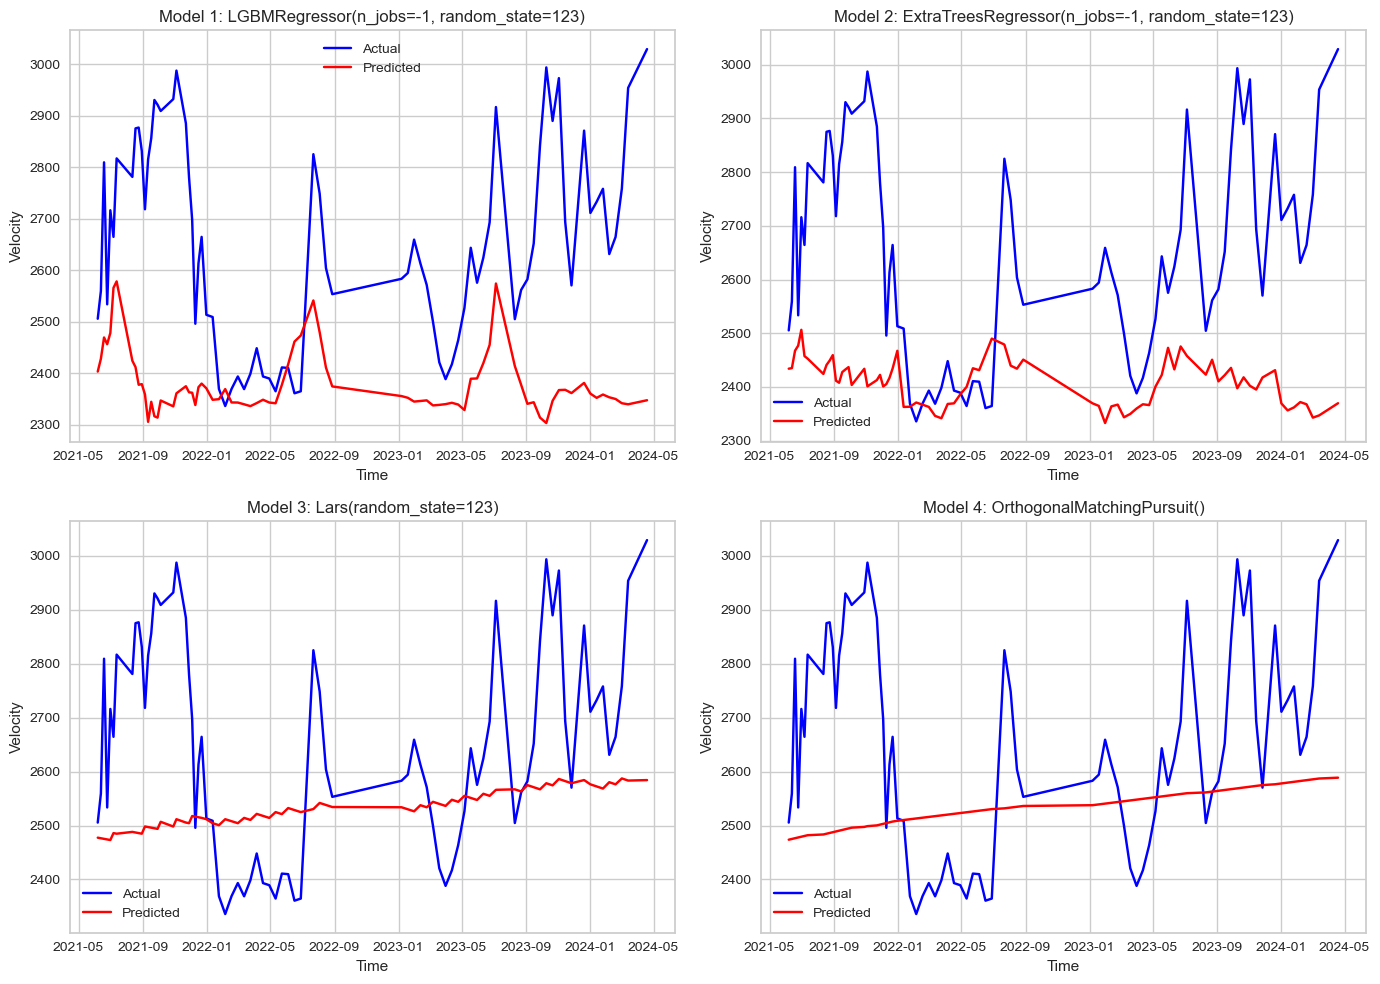

In [58]:
# Plot the results of the top 4 models
plt.figure(figsize=(14, 10))

for i, model in enumerate(comparison):
    # Predict on the test data
    predictions = predict_model(model, data=test)
    
    # Plot actual vs predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(test['time'], test['velocity'], label='Actual', color='blue')
    plt.plot(test['time'], predictions['prediction_label'], label='Predicted', color='red')
    plt.title(f'Model {i+1}: {model}')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.legend()

plt.tight_layout()
plt.savefig('../figures/' + point_name + '_top4_models.png')
plt.show()

The LightGBM and RF captured the dramatic seasonal changes while Linear Regression and Orthogonal Matching only found slight long-term trends. It is necessary to capture the seasonality of the glacier in our problem as it changes dramatically and has been increasing over the years. Linear Regression and Orthogonal Matching do not fit the data in the way we need them to.

For further analysis, let's plot the error to visualize the best fit for each model.

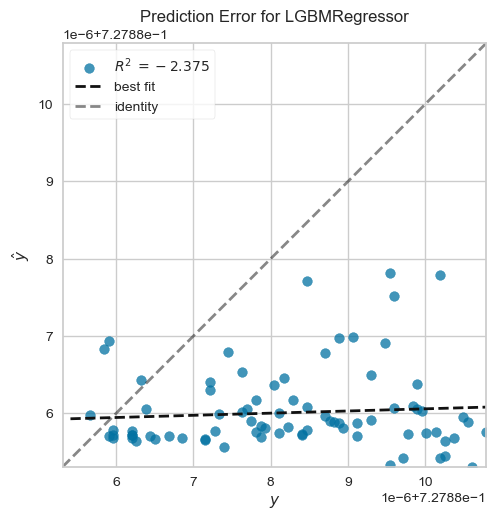

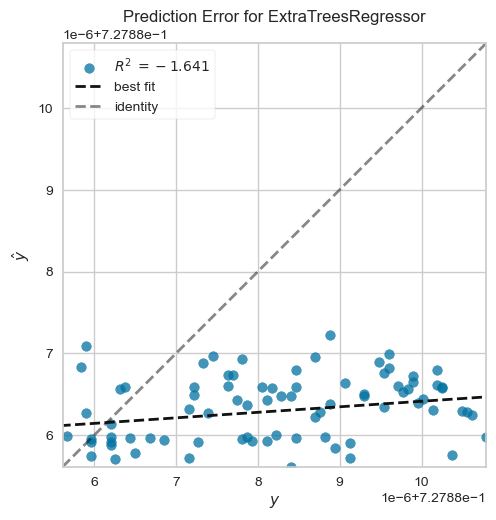

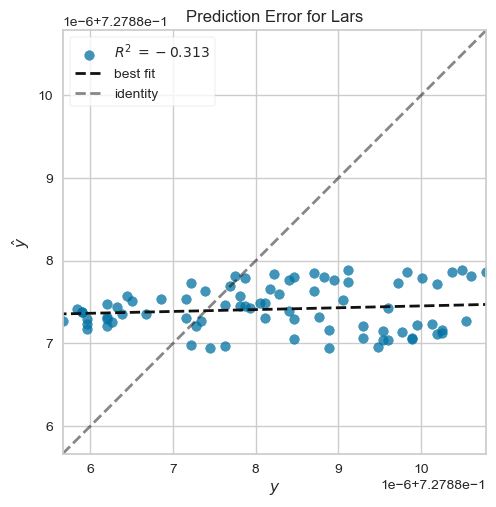

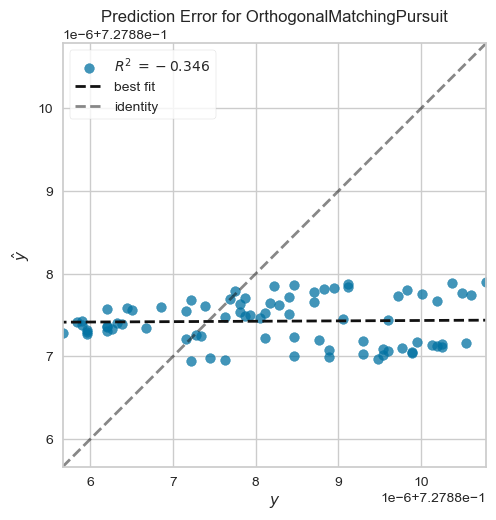

In [59]:
for model in comparison:
    plot_model(model, plot='error')

Here, it is easier to visualize how poorly Linear Regression and Orthogonal Matching performed. The best fit and identity lines are semi-perpendicular, indicating that they were very wrong.

Random Forest (RF) performed the best on the test data. It captured the seasonal peaks better than the other top models. We will use RF moving forward.

### 5. Tune the model

Here we use hyperparameter tuning to optimize our RF model. We'll optimize it under mean absolute error (MAE).

In [60]:
dt = create_model('rf', fold=6)

tune_model(dt, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,86.0378,11436.1051,106.9397,0.4994,0.0468,0.0385
1,86.0140,8620.7155,92.8478,-9.0026,0.0406,0.0385
2,29.9798,2610.1911,51.0900,-0.2040,0.0218,0.0128
3,104.8590,25992.8299,161.2229,-0.0720,0.0661,0.0423
4,160.0537,57291.7097,239.3569,-0.7226,0.0957,0.0611
5,272.9271,79684.5234,282.2845,-17.8930,0.1126,0.1152
Mean,123.3119,30939.3458,155.6236,-4.5658,0.0640,0.0514
Std,76.9919,28213.6082,81.9794,6.7939,0.0316,0.0318


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,102.6127,26768.2570,163.6101,-0.1718,0.0715,0.0440
1,133.5176,18688.8006,136.7070,-20.6845,0.0627,0.0594
2,113.6081,15074.7591,122.7793,-5.9534,0.0544,0.0493
3,125.6616,36816.5277,191.8763,-0.5184,0.0796,0.0503
4,207.5261,76326.2843,276.2721,-1.2949,0.1124,0.0805
5,133.4729,22032.6915,148.4341,-4.2239,0.0633,0.0552
Mean,136.0665,32617.8867,173.2798,-5.4745,0.0740,0.0564
Std,33.7922,20720.7541,50.9116,7.1097,0.0189,0.0118


Fitting 6 folds for each of 10 candidates, totalling 60 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


RandomForestRegressor(n_jobs=-1, random_state=123)

The tuned RF model performed very slightly better than the original. We'll use these parameters moving forward.

Hyperparameter tuning in this case didn't affect the score much but we'll take what we can get. Here, we can see that changing small parameters in the decision tree like the `max_depth` and `min_samples_leaf` can make a difference in model performance.


### 6. Time analysis

Now, let's plot the time analysis of the top models. Since we plan to run these models on larger datasets in future project tiers, it is important that they do not take up too much time.

Plot the amount of time each model took to run on the data. While this is good information for a small dataset, it will likely need to be run again for larger datasets in future project tiers.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,276.3485,111612.7075,334.0849,-2.0271,0.1290,0.1001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,247.7728,92046.3652,303.3914,-1.4964,0.1159,0.0894


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,180.5390,50502.5256,224.7277,-0.3697,0.0840,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,182.2455,51593.0120,227.1410,-0.3993,0.0850,0.0664


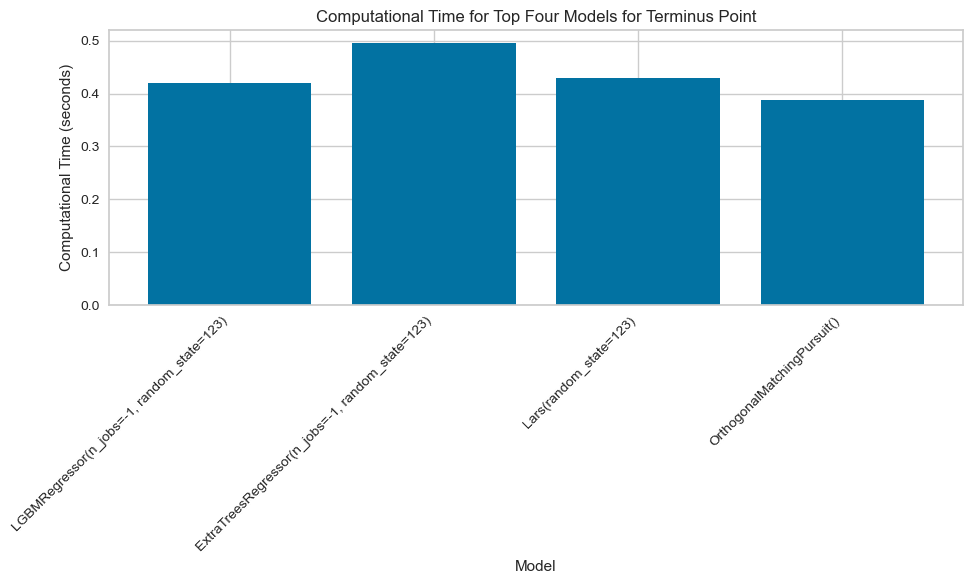

In [61]:
# Initialize a dictionary to store the computational times
comp_times = {}

# Measure the computational time for each model
for model in comparison:
    start_time = time.time()
    predict_model(model, data=test)
    end_time = time.time()
    
    # Calculate the computational time
    comp_time = end_time - start_time
    comp_times[model] = comp_time

# Plot the computational times
plt.figure(figsize=(10, 6))
plt.bar(range(len(comp_times)), list(comp_times.values()), align='center')
plt.xticks(range(len(comp_times)), [str(model) for model in comp_times.keys()], rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Computational Time (seconds)')
plt.title('Computational Time for Top Four Models for ' + point_name.capitalize() + ' Point')
plt.tight_layout()
plt.savefig('../figures/computational_time_' + point_name + '.png', dpi=300)
plt.show()

RF performed the best and took the least amount of time. LGBMRegressor tends to take more time than RF, and, considering that RF performed better on the test data, we will use RF with the hyperparameters identified earlier in this notebook for predictions.

### 7. Save the model

Save the model for future use.

In [62]:
save_model(dt, '../models/' + point_name + '_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('date_feature_extractor',
                  TransformerWrapper(include=['time'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['time', 'series'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(n_jobs=-1, random_state=123))]),
 '../models/terminus_model.pkl')